<a href="https://colab.research.google.com/github/theKaganOz/TensorFlow-Course/blob/master/perMLP_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Analysis Functions

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 03:01:33 2024

@author: kagan

This module contains spectral time series analysis tools, namely:
    - A unit root test based on spectral properties, as proposed by Dickey & Akdi (1995)
    - A generalization of Fisher's test for hidden periodicities (Akdi, 2012)
    - A periodogram-based method of computing the spectral distance between two times series

"""

import pandas as pd
import numpy  as np

from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import periodogram

class SpectralAnalyzer:
    """
    This class is initialized with a time series, and upon initialization,
    it automatically computes the stationarity of a time series.
    If "auto_diff" is enabled, the series is differenced until it no longer
    contains a unit root.
    If any difference of the series does not contain a unit root,
    hidden periods will automatically be identified.
    A method named subdivide will divide the time series into equal periods of
    given length.
    """

    def __init__(self, time_series,
                 significance_level,
                 n_hidden_components):
        self.__n_hidden_components = n_hidden_components
        self.__significance_level = significance_level
        # The signal itself
        self.__signal = time_series
        # Residual variance estimate
        self.__residual_variance_estimate = self.form_model_and_forecast(time_series,
                                                                         pacf_threshold = 0.1)[0].params["sigma2"]
        # Linearly tested unit root
        self.__linear_unit_root   =  adfuller(time_series)[1]
        # Periodically tested unit root
        self.__periodic_unit_root = self.__periodogram_unit_root_test()[0]
        # Form period-amplitude map
        self.__hidden_periodic_components = self.__form_period_amplitude_map()
    def get_hidden_periodic_components(self):
        return self.__hidden_periodic_components

    def form_model_and_forecast(self, series, pacf_threshold):
    # Perform stationarity test
        stationarity_test = adfuller(series)[1] < 0.05
        print("Stationarity: ", stationarity_test)
        integration_order = 0
        # If the series is stationary, get partial autocorrelation function and model using lags that are above the threshold
        partial_autocorrelations = []
        # Integration order is zero
        if stationarity_test == True:
            print("Stationarity at order ", integration_order)
            partial_autocorrelations = list(np.argwhere(pacf(series) > pacf_threshold))[1:]
        else:
            differenced_series = series.diff().dropna()
            print("Series is differenced")
            stationarity_test = adfuller(differenced_series)[1] < 0.05
            print("Differenced stationarity test: ", stationarity_test)
            if stationarity_test:
                integration_order = 1
                partial_autocorrelations = list(np.argwhere(pacf(differenced_series) > pacf_threshold))[1:]

        print("Stationarity at order", integration_order)
        model = ARIMA(series, order = (partial_autocorrelations, integration_order, 0)).fit()
        print("Model mean sum of squared errors: ", model.mse)
        print("Model AICC: ", model.aicc)
        print("Model mean forecast: ", model.get_forecast().predicted_mean)
        print("Model forecast confidence interval: ", model.get_forecast().conf_int(alpha=0.05))
        return model, model.aicc, model.mse, model.get_forecast()


    def __periodogram_unit_root_test(self):

        significance_level = str(self.__significance_level)
        critical_values = {"0.01" : 0.0348,
                           "0.05": 0.178,
                           "0.1" : 0.368}

        frequencies, amplitudes = periodogram(self.__signal)
        omega = np.degrees(frequencies[1])
        # I(w1)
        per = amplitudes[1]
        test_statistic = (2 * (1 - np.cos(2 * np.pi/len(self.__signal) )) / self.__residual_variance_estimate) * per


        print("Test stat for {0} is {1}".format(self.__signal.name, test_statistic))
        stationary = test_statistic < critical_values[significance_level]
        return stationary, test_statistic


    def __form_period_amplitude_map(self):
        def important_frequencies(signal, n, extract_important = True):
            def get_v_statistic_at_order_n(amplitude_dataframe, n):
                total = amplitude_dataframe.sum()
                print("Total: {0}".format(total))
                sum_at_n = amplitude_dataframe[:n].sum()
                print("Total up to n={0}: {1}".format(n, sum_at_n))
                amplitude_at_n = amplitude_dataframe[n]
                print("Amplitude at n={0}: {1}".format(n, amplitude_at_n))
                return amplitude_at_n / (total - sum_at_n)
            def compute_critical_value(confidence_level, series):
                return 1 - (confidence_level/len(series)) ** (1/(len(series)-1))
            # get highest n frequencies
            # get v values
            v_statistics    = [get_v_statistic_at_order_n(period_ampl["Amplitudes"], i) for i in range(n)]
            critical_value = compute_critical_value(0.05, signal)
            results_table   = period_ampl.copy()[0:n]
            results_table["V"] = v_statistics
            print("Critical value: ", critical_value)
            print(results_table)
            # Filter important frequencies
            important_components = results_table[results_table["V"] >= critical_value]
            if extract_important:
                return important_components
            else:
                return results_table

        frequencies, amplitudes = periodogram(self.__signal)
        # to overcome the initial zero frequency.
        frequencies = frequencies[1:]
        amplitudes  = amplitudes[1:]
        print("Computed periodogram.")
        # convert frequencies to periods
        print("Converting frequencies to periods.")
        periods = np.reciprocal(frequencies)

        # form a dictionary to hold frequency amplitude pairs
        period_ampl = pd.DataFrame({"Periods": periods, "Amplitudes":amplitudes})
        # sort these values by amplitudes
        period_ampl = period_ampl.sort_values(by = "Amplitudes", ascending = False)
        # get the sum of all amplitudes
        amplitude_sum = period_ampl["Amplitudes"].sum()
        important_components = important_frequencies(self.__signal, self.__n_hidden_components)

        return important_components

# Periodic Segmentation of the Training and Test Datasets

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 27 21:50:18 2024

@author: kagan
"""
import numpy      as np
import tensorflow as tf
import pandas as pd

def consecutive_periods_tf(series, period_size):
    data = pd.Series(series)
    X, y = [], []

    for i in range(0, len(data) - 2 * period_size + 1, period_size):
        period1 = data.iloc[i:i + period_size].tolist()
        period2 = data.iloc[i + period_size:i + 2 * period_size].tolist()
        X.append(period1)
        y.append(period2)

    # Convert lists to TensorFlow tensors
    X_tensor = tf.constant(X, dtype=tf.float32)
    y_tensor = tf.constant(y, dtype=tf.float32)

    batch_size = 1
    dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor)).batch(batch_size)

    return dataset, X_tensor, y_tensor
def periodize_signal(signal,
                     period_size):
    dataset_length = len(signal)
    number_of_periods = dataset_length // period_size

    upper, lower = 0, period_size
    boundaries = [(upper, lower)]
    for i in range(number_of_periods):
        upper += period_size
        lower += period_size
        boundaries.append((upper, lower))

    X = []
    y = []
    for i in range(1, len(boundaries) - 1):
        l, u   = boundaries[i][0]    , boundaries[i][1]
        ln, un = boundaries[i + 1][0], boundaries[i + 1][1]
        sub_sequence_current = signal[l:u]
        sub_sequence_next    = signal[ln:un]
        X.append(sub_sequence_current)
        y.append(sub_sequence_next)

    # Parameters
    input_length = period_size  # Length of the input sequence
    num_features = 1  # Number of features in each time step of the input sequence (univariate time series)

    # Prepare for output
    X = np.array(X[:-1])
    y = np.array(y[:-1])

    X = X.reshape(-1, period_size, num_features)
    y = y.reshape(-1, period_size, num_features)
    # Prepare for neural nets
    batch_size = 1
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)

    return dataset, X, y



# Simulating Time Series

In [ ]:
# prompt: simulate a non-stationary time series and periodize using the above function. obtain the time series in pandas dataframe format

import pandas as pd
import numpy as np

def simulate_non_stationary_time_series(length=100, periods=[5, 100, 20]):
    """Simulates a non-stationary time series with specified periods."""
    time_series = np.random.randn(length)
    for period in periods:
      time_series += np.sin(2 * np.pi * np.arange(length) / period)
    # Introduce a trend
    time_series += np.linspace(0, 100, length)
    return pd.DataFrame({'value': time_series}, index=pd.RangeIndex(length))


# Simulate the time series
df = simulate_non_stationary_time_series(length = 500, periods = [10, 20, 30])
# Split region
split = len(df)//2
training_region = df[:split]
test_region     = df[split:]


# Dataset Preparation for Learning

In [ ]:
spectral_analyzer = SpectralAnalyzer(training_region["value"], 0.05, 10)

Stationarity:  False
Series is differenced
Differenced stationarity test:  True
Stationarity at order 1
Model mean sum of squared errors:  2.6536386953643722
Model AICC:  954.6841940283259
Model mean forecast:  250    51.527722
dtype: float64
Model forecast confidence interval:       lower value  upper value
250    48.329217    54.726226
Test stat for value is 7.494924924416822
Computed periodogram.
Converting frequencies to periods.
Total: 53023.27400960949
Total up to n=0: 0.0
Amplitude at n=0: 31601.535398232743
Total: 53023.27400960949
Total up to n=1: 31601.535398232743
Amplitude at n=1: 8031.367881849212
Total: 53023.27400960949
Total up to n=2: 39632.903280081955
Amplitude at n=2: 3563.769338192176
Total: 53023.27400960949
Total up to n=3: 43196.67261827413
Amplitude at n=3: 2162.363596071938
Total: 53023.27400960949
Total up to n=4: 45359.03621434607
Amplitude at n=4: 1313.2584466490748
Total: 53023.27400960949
Total up to n=5: 46672.29466099515
Amplitude at n=5: 767.9878853924

In [ ]:
spectral_analyzer.get_hidden_periodic_components()

,Periods,Amplitudes,V
0,250.000000,31601.535398,0.595994
1,125.000000,8031.367882,0.374917
2,83.333333,3563.769338,0.266144
3,62.500000,2162.363596,0.220052
4,50.000000,1313.258447,0.171349
5,41.666667,767.987885,0.120924
8,27.777778,555.942126,0.093060
6,35.714286,519.555703,0.076500
7,31.250000,384.570753,0.123337
9,25.000000,364.310606,0.088362


In [ ]:
period_size  = 30
num_features = 1
dataset_train, X_train, y_train = periodize_signal(training_region["value"], period_size)
dataset_test,  X_test, y_test   = periodize_signal(test_region["value"], period_size)
batch_size = 1
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [ ]:
from tensorflow.signal import rfft as tf_rfft
def spectral_magnitude_loss_function(y_true, y_pred):
    psd_squared_difference = tf.math.abs(tf_rfft(y_true) - tf_rfft(y_pred))
    return tf.reduce_mean(psd_squared_difference)
def spectral_phase_loss_function(y_true, y_pred):
    # Compute the phase difference between predicted and true signals.
    phase_diff = tf.math.angle(tf_rfft(y_true)) - tf.math.angle(tf_rfft(y_pred))

    # Take the absolute value to ensure positive loss values.
    phase_diff_abs = tf.math.abs(phase_diff)

    # Compute the mean squared phase difference
    return tf.reduce_mean(phase_diff_abs)
def spectral_loss_function(y_true, y_pred):
    return spectral_magnitude_loss_function(y_true, y_pred) + spectral_phase_loss_function(y_true, y_pred)

In [ ]:
def spectral_magnitude_loss_function_sqr(y_true, y_pred):
    # Compute the magnitude squared difference of the Fourier Transforms
    magnitude_diff_squared = tf.math.square(tf.math.real(tf_rfft(y_true)) - tf.math.real(tf_rfft(y_pred))) + \
                             tf.math.square(tf.math.imag(tf_rfft(y_true)) - tf.math.imag(tf_rfft(y_pred)))
    return tf.reduce_mean(magnitude_diff_squared)

def spectral_phase_loss_function_sqr(y_true, y_pred):
    # Compute the phase difference between predicted and true signals
    phase_diff = tf.math.angle(tf_rfft(y_true)) - tf.math.angle(tf_rfft(y_pred))

    # Square the phase difference
    phase_diff_squared = tf.math.square(phase_diff)

    # Compute the mean squared phase difference
    return tf.reduce_mean(phase_diff_squared)

def spectral_loss_function_sqr(y_true, y_pred):
    # Combine the magnitude and phase loss
    return spectral_magnitude_loss_function(y_true, y_pred) + spectral_phase_loss_function(y_true, y_pred)

def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

def composite_loss_function(y_true, y_pred):
    return spectral_loss_function(y_true, y_pred) + MSE(y_true, y_pred)

def range_loss_function(y_true, y_pred):
    range_true = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    range_pred = tf.reduce_max(y_pred) - tf.reduce_min(y_pred)
    return tf.math.abs(range_true - range_pred)

def composite_loss_function_range(y_true, y_pred):
    return composite_loss_function(y_true, y_pred) + range_loss_function(y_true, y_pred)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Flatten, Dense, Input, Activation
from tensorflow.keras.utils import get_custom_objects
def x_plus_sin_squared(x):
    return x + tf.math.square(tf.math.sin(x))
def x_plus_sin_cos(x):
    return x * tf.math.sin(x) + x * tf.math.cos(x)
get_custom_objects().update({'x_plus_sin_squared': Activation(x_plus_sin_squared)})
get_custom_objects().update({'x_plus_sin_cos': Activation(x_plus_sin_cos)})

In [ ]:
get_custom_objects().update({'spectral_loss_function': spectral_loss_function})

In [ ]:
# prompt: create function that generates a multilayer perceptron similar to the create_cnn_model function, make sure input layer is consistent with the dataset shape


def create_mlp_model(input_shape,
                     number_of_dense_layers=1,
                     loss_function = "mean_squared_error"):
  """Creates a multilayer perceptron model.

  Args:
    input_shape: Tuple representing the shape of the input data.

  Returns:
    A compiled Keras model.
  """
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  for i in range(number_of_dense_layers):
    model.add(Dense(period_size, activation=x_plus_sin_squared))
  model.compile(optimizer='adam', loss=loss_function, metrics=["mean_squared_error"])
  return model

def train_and_assess_model(period_size,
                           num_features,
                           epochs,
                           train_dataset,
                           test_dataset,
                           number_of_layers,
                           loss_function="mean_squared_error",
                           plot_error=True):
  # Example usage (assuming your data is shaped as (period_size, num_features)):
  input_shape = (period_size, num_features)
  mlp_model = create_mlp_model(input_shape, number_of_layers, loss_function)
  mlp_model.summary()
  model_history = mlp_model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, shuffle=False)


  predictions_mlp = mlp_model.predict(test_dataset)
  forecast_error = y_test.flatten() - predictions_mlp.flatten()
  if plot_error:
    down, up = 0, len(predictions_mlp.flatten())//2
    _ = plt.figure(figsize = (15, 5))
    _ = plt.subplot(2, 1, 1)
    _ = plt.plot(y_test.flatten()[down:up], label = "Test")
    _ = plt.plot(predictions_mlp.flatten()[down:up], label = "Öngörü")
    _ = plt.legend()

    _ = plt.subplot(2, 1, 2)
    _ = plt.plot(y_test.flatten()[up:], label = "Test")
    _ = plt.plot(predictions_mlp.flatten()[up:], label = "Öngörü")
    _ = plt.legend()
    return model_history




In [ ]:
import matplotlib.pyplot as plt

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_24 (Flatten)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930 (3.63 KB)

 Trainable params: 930 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1169.0374 - mean_squared_error: 1169.0374 - val_loss: 12796.7939 - val_mean_squared_error: 12796.7939
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1016.0139 - mean_squared_error: 1016.0139 - val_loss: 11114.6631 - val_mean_squared_error: 11114.6631
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 899.3900 - mean_squared_error: 899.3900 - val_loss: 9728.0723 - val_mean_squared_error: 9728.0723
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 794.7962 - mean_squared_error: 794.7962 - val_loss: 8507.9404 - val_mean_squared_error: 8507.9404
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 704.1430 - mean_squared_error: 704.1430 - val_loss: 7426.6899 - val_mean_squared_error: 7426.6899
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 621.9028 - mean_squared_error: 621.9028 - val_loss: 6489.4771 - val_mean_squared_error: 6489.4771
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 550.5143 - 

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930 (3.63 KB)

 Trainable params: 930 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 122.5904 - mean_squared_error: 907.3932 - val_loss: 450.7073 - val_mean_squared_error: 10069.8662
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 111.4168 - mean_squared_error: 801.6795 - val_loss: 404.8545 - val_mean_squared_error: 8720.2344
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.6194 - mean_squared_error: 708.4257 - val_loss: 366.2655 - val_mean_squared_error: 7629.9805
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92.9706 - mean_squared_error: 637.0765 - val_loss: 328.1111 - val_mean_squared_error: 6716.7622
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84.2399 - mean_squared_error: 571.9022 - val_loss: 292.2872 - val_mean_squared_error: 5852.3862
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76.0940 - mean_squared_error: 509.2970 - val_loss: 256.8275 - val_mean_squared_error: 5097.8647
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.7720 - mean_squared_erro

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_26 (Flatten)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930 (3.63 KB)

 Trainable params: 930 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 911.3792 - mean_squared_error: 788.4479 - val_loss: 9230.2510 - val_mean_squared_error: 8767.3389
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 793.9385 - mean_squared_error: 677.2869 - val_loss: 7976.7188 - val_mean_squared_error: 7539.0801
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 699.8783 - mean_squared_error: 589.0696 - val_loss: 6904.7349 - val_mean_squared_error: 6492.3433
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 615.1920 - mean_squared_error: 510.3851 - val_loss: 5999.6499 - val_mean_squared_error: 5612.0820
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 545.7030 - mean_squared_error: 446.2068 - val_loss: 5228.0239 - val_mean_squared_error: 4863.7632
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 487.1333 - mean_squared_error: 392.8898 - val_loss: 4595.6235 - val_mean_squared_error: 4252.3345
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 435.7973 - mean_squ

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_27 (Flatten)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930 (3.63 KB)

 Trainable params: 930 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 52.2296 - mean_squared_error: 932.5052 - val_loss: 237.0145 - val_mean_squared_error: 10999.3311
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.5770 - mean_squared_error: 915.7490 - val_loss: 220.8801 - val_mean_squared_error: 10760.1592
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.3715 - mean_squared_error: 898.5308 - val_loss: 204.1736 - val_mean_squared_error: 10511.4072
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.7317 - mean_squared_error: 881.8070 - val_loss: 189.3607 - val_mean_squared_error: 10272.0469
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.2643 - mean_squared_error: 861.9661 - val_loss: 173.6556 - val_mean_squared_error: 9991.4150
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.0714 - mean_squared_error: 843.8126 - val_loss: 158.3129 - val_mean_squared_error: 9711.1592
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.3177 - mean_squared_erro

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930 (3.63 KB)

 Trainable params: 930 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 1313.8503 - mean_squared_error: 1116.6606 - val_loss: 13113.5928 - val_mean_squared_error: 12340.0156
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1160.4020 - mean_squared_error: 975.3469 - val_loss: 11468.4619 - val_mean_squared_error: 10742.6992
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1034.3134 - mean_squared_error: 858.5283 - val_loss: 10120.0244 - val_mean_squared_error: 9432.9453
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 935.9598 - mean_squared_error: 766.4323 - val_loss: 8954.4443 - val_mean_squared_error: 8296.9922
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 839.9771 - mean_squared_error: 678.3928 - val_loss: 7894.1426 - val_mean_squared_error: 7267.4487
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 755.7574 - mean_squared_error: 601.2922 - val_loss: 6937.4785 - val_mean_squared_error: 6337.7964
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 676.0077 

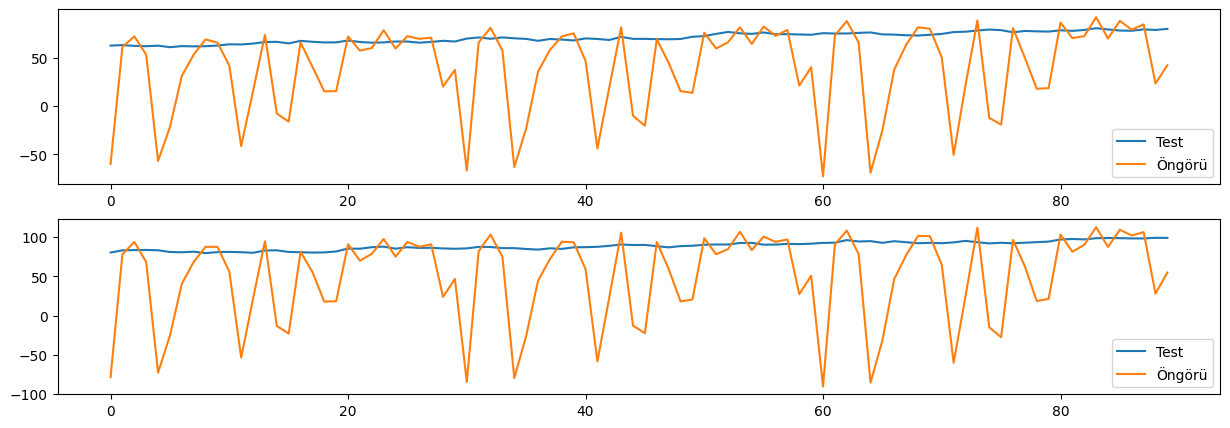

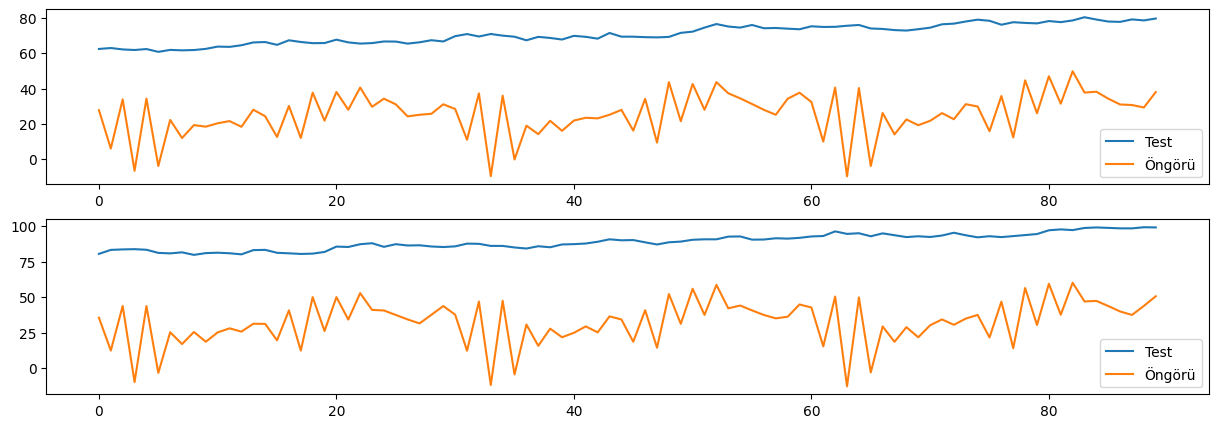

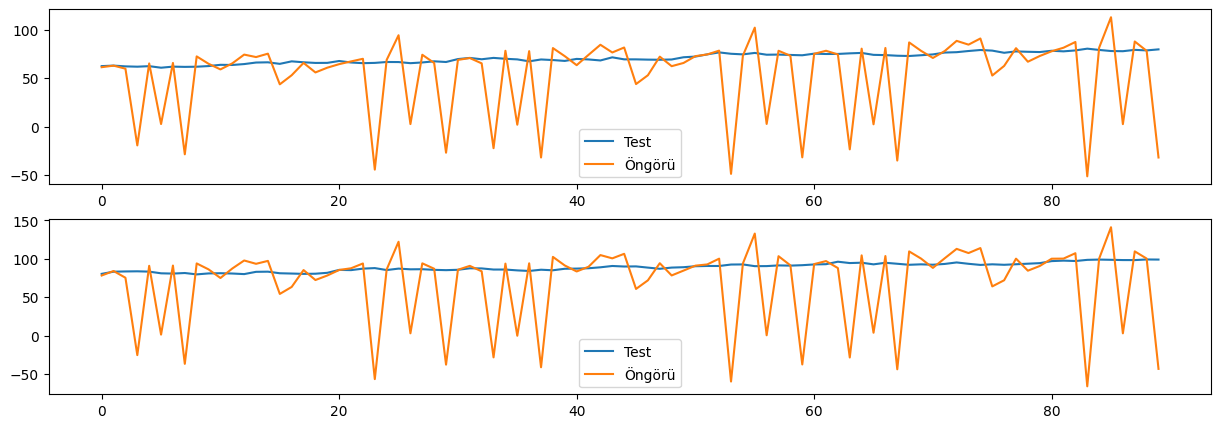

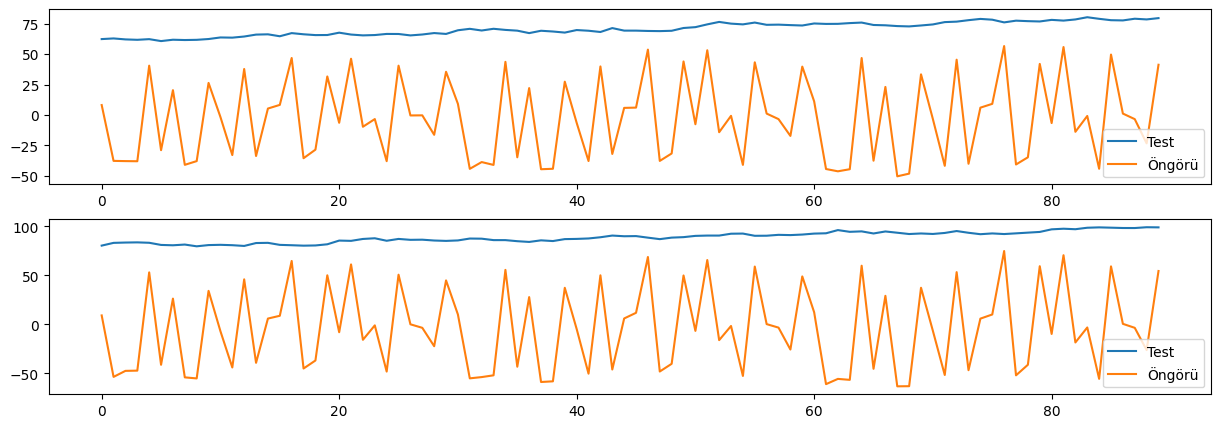

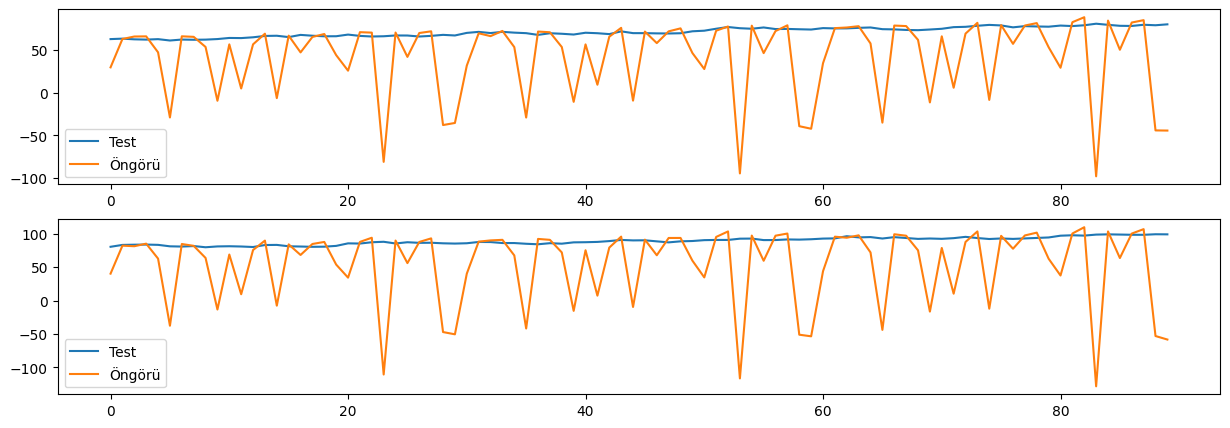

In [ ]:
EPOCHS = 10
COUNT_LAYERS = 1
mse_model = train_and_assess_model(period_size=period_size, num_features=num_features, epochs=EPOCHS, train_dataset=train_dataset, test_dataset=test_dataset, number_of_layers=COUNT_LAYERS, loss_function="mean_squared_error", plot_error=True)
spectral_loss_model = train_and_assess_model(period_size=period_size, num_features=num_features, epochs=EPOCHS, train_dataset=train_dataset, test_dataset=test_dataset, number_of_layers=COUNT_LAYERS, loss_function=spectral_loss_function, plot_error=True)
composite_loss_model = train_and_assess_model(period_size=period_size, num_features=num_features, epochs=EPOCHS, train_dataset=train_dataset, test_dataset=test_dataset, number_of_layers=COUNT_LAYERS, loss_function=composite_loss_function, plot_error=True)
range_loss_model = train_and_assess_model(period_size=period_size, num_features=num_features, epochs=EPOCHS, train_dataset=train_dataset, test_dataset=test_dataset, number_of_layers=COUNT_LAYERS, loss_function=range_loss_function, plot_error=True)
composite_range_loss_model = train_and_assess_model(period_size=period_size, num_features=num_features, epochs=EPOCHS, train_dataset=train_dataset, test_dataset=test_dataset, number_of_layers=COUNT_LAYERS, loss_function=composite_loss_function_range, plot_error=True)

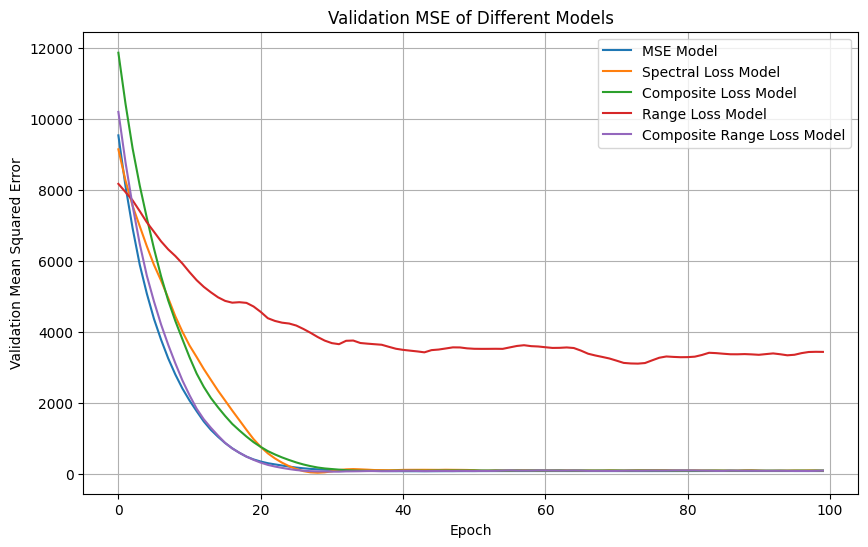

In [ ]:
# prompt: plot val_mean_squared error of all three models above in same subplot

import matplotlib.pyplot as plt

# Assuming mse_model, spectral_loss_model, and composite_loss_model are your model history objects.
# Extract the validation mean squared error for each model.

plt.figure(figsize=(10, 6))
plt.plot(mse_model.history['val_mean_squared_error'], label='MSE Model')
plt.plot(spectral_loss_model.history['val_mean_squared_error'], label='Spectral Loss Model')
plt.plot(composite_loss_model.history['val_mean_squared_error'], label='Composite Loss Model')
plt.plot(range_loss_model.history['val_mean_squared_error'], label='Range Loss Model')
plt.plot(composite_range_loss_model.history['val_mean_squared_error'], label="Composite Range Loss Model")
plt.xlabel('Epoch')
plt.ylabel('Validation Mean Squared Error')
plt.title('Validation MSE of Different Models')
plt.legend()
plt.grid(True)
plt.show()